# Import Libs

In [1]:
#import libs

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #optimizer of the function
from torchsummary import summary


#sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#visualization
import matplotlib.pyplot as plt

#systemn libs
import gc

#data processing
import numpy as np
import pandas as pd
from pytorchtools import EarlyStopping

# Load the data

In [3]:
#load the data

#signals
X_VEB = pd.read_csv('input/data_VEB_v2.csv',header=None, index_col=None)
X_VEB = X_VEB.T

X_SVEB = pd.read_csv('input/data_SVEB_v2.csv',header=None, index_col=None)
X_SVEB = X_SVEB.T

#labels
y_VEB = pd.read_csv('input/labels_VEB_v2.csv',header=None, index_col=None)
y_SVEB = pd.read_csv('input/labels_SVEB_v2.csv',header=None, index_col=None)

#meta-features
meta_VEB = pd.read_csv('input/meta_features_VEB_v2.csv',header=None, index_col=None)
meta_SVEB = pd.read_csv('input/meta_features_SVEB_v2.csv',header=None, index_col=None)

#get numpy matrixes
X_VEB = X_VEB.values
y_VEB = y_VEB.values
meta_VEB = meta_VEB.values

X_SVEB = X_SVEB.values
y_SVEB = y_SVEB.values
meta_SVEB = meta_SVEB.values


#merge datasets togather
X = np.concatenate((X_VEB,X_SVEB))
y = np.concatenate((y_VEB,y_SVEB))
meta = np.concatenate((meta_VEB.T,meta_SVEB.T))

del X_VEB,X_SVEB,y_VEB,y_SVEB,meta_VEB,meta_SVEB
gc.collect()

0

# Data exploration

In [4]:
#unique classes
np.unique(y)

array(['A', 'E', 'N', 'S', 'V', 'a', 'j'], dtype=object)

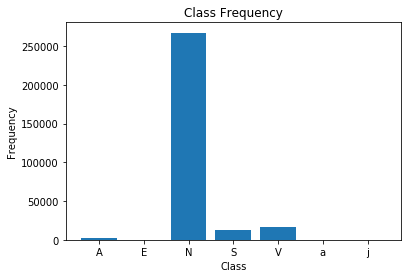

In [5]:
#check the class balance

unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [6]:
print('Total number of samples: ',y.shape[0])
print('Number of "A" :', np.where(y == 'A')[0].shape[0])
print('Number of "a" :', np.where(y == 'a')[0].shape[0])
print('Number of "S" :', np.where(y == 'S')[0].shape[0])
print('Number of "j" :', np.where(y == 'j')[0].shape[0])
print('Number of "V" :', np.where(y == 'V')[0].shape[0])
print('Number of "E" :', np.where(y == 'E')[0].shape[0])
print('Number of "N" :', np.where(y == 'N')[0].shape[0])

Total number of samples:  299485
Number of "A" : 2538
Number of "a" : 151
Number of "S" : 12147
Number of "j" : 229
Number of "V" : 17021
Number of "E" : 106
Number of "N" : 267293


In [7]:
np.where(y == 'E')[0].shape

(106,)

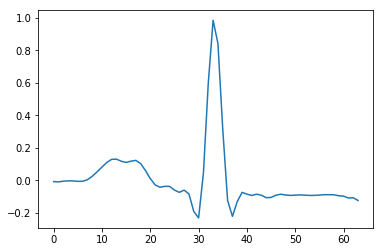

In [8]:
plt.plot(X[100,:])

Conclusions:
1. data is imbalanced, need usual KFOLD + balancing of each class\
2. use lower amount of folds (3)


# Training

In [9]:
#label encoiding of the data, for pytorch implementation

enc = LabelEncoder()
y = enc.fit_transform(y)


#data converter, just in case
transDict = {
     0:'A',
     1:'E',
     2:'N',
     3:'S',
     4:'V',
     5:'a',
     6:'j',
}

def translateTarget(y_loc):
    y_out = np.zeros((y_loc.shape[0],1),dtype='O')
    for i in range(y_loc.shape[0]):
        y_out[i] = transDict[y_loc[i]]
    return y_out

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
def upsampling(X_loc,y_loc,meta_loc):
    
    UniqClass = np.unique(y_loc)
    
    mostQreq = 0
    numSam_max = 0

    for i in UniqClass:
        numSam = np.where(y_loc == i)[0].shape[0]
        if numSam_max < numSam:
            numSam_max = numSam
            mostQreq = i


    for i in UniqClass:
        if i == mostQreq:
            continue
        else:
            #applying of upsampling trainng set
            X_US = np.zeros((numSam_max - np.where(y_loc == i)[0].shape[0],X_loc.shape[1]))
            X_minor = X_loc[np.where(y_loc == i)[0]]
            y_minor = np.zeros((X_US.shape[0])) + i
            meta_loc_US = np.zeros((numSam_max - np.where(y_loc == i)[0].shape[0],meta_loc.shape[1]))

            for j in range(X_US.shape[0]):
                ind = np.random.randint(0,X_minor.shape[0])
                X_US[j,:] = X_minor[ind,:]
                meta_loc_US[j,:] = meta_loc[ind,:]

            X_loc = np.concatenate((X_loc,X_US))
            y_loc = np.concatenate((y_loc,y_minor))
            meta_loc = np.concatenate((meta_loc,meta_loc_US))

    # need to add meta features
    #need to add random permutation
    temp = np.zeros((X_loc.shape[0],X_loc.shape[1]+meta_loc.shape[1]+1))
    temp[:,0:64] = X_loc
    temp[:,64:64+9] = meta_loc
    temp[:,64+9] = y_loc

    temp = np.take(temp,np.random.permutation(temp.shape[0]),axis=0,out=temp)

    X_loc = temp[:,0:64]
    meta_loc = temp[:,64:64+9] 
    y_loc = temp[:,64+9]
    
    return X_loc,y_loc,meta_loc

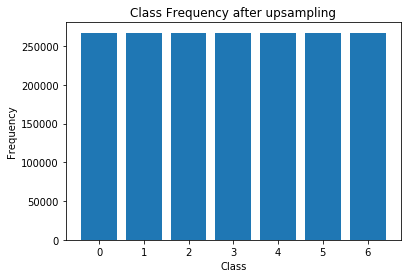

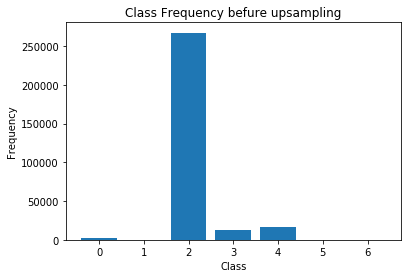

In [11]:
#check the class balance

y_loc = y
X_loc = X
meta_loc = meta

X_loc,y_loc,meta_loc = upsampling(X_loc,y_loc,meta_loc)

unique, counts = np.unique(y_loc, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency after upsampling')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()


unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency befure upsampling')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [12]:
class HP():
    def __init__(self):
        self.dropout_rate = 0.5

hyperparams = HP()

class Net(nn.Module):
    def __init__(self,hyperparams):
        super(Net, self).__init__()
        # we define convolutional layers 
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 1, padding = 3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 7, stride = 1, padding = 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 7, stride = 1, padding = 3)
        self.bn3 = nn.BatchNorm1d(256)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(in_features = 2048, out_features = 256)
        self.fcbn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 7)       
        self.dropout_rate = hyperparams.dropout_rate

    def forward(self, x):
        # we apply the convolution layers, followed by batch normalisation, 
        # maxpool and relu x 3
        s = self.bn1(self.conv1(x))        # batch_size x 64 x 64 x 1
        s = F.relu(F.max_pool1d(s, 2))     # batch_size x 64 x 32 x 1
        s = self.bn2(self.conv2(s))        # batch_size x 128 x 32 x 1
        s = F.relu(F.max_pool1d(s, 2))     # batch_size x 128 x 16 x 1
        s = self.bn3(self.conv3(s))        # batch_size x 256 x 16 x 1
        s = F.relu(F.max_pool1d(s, 2))     # batch_size x 256 x 8 x 1

        # flatten the output for each image
        s = s.view(-1, 8*256)  # batch_size x 8*256

        # apply 2 fully connected layers with dropout
        s = F.dropout(F.relu(self.fcbn1(self.fc1(s))), 
            p=self.dropout_rate, training=self.training)    # batch_size x 256
        s = self.fc2(s)                                     # batch_size x 7

        return F.log_softmax(s, dim=1)


net = Net(hyperparams)
summary(net,(1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 64]             512
       BatchNorm1d-2               [-1, 64, 64]             128
            Conv1d-3              [-1, 128, 32]          57,472
       BatchNorm1d-4              [-1, 128, 32]             256
            Conv1d-5              [-1, 256, 16]         229,632
       BatchNorm1d-6              [-1, 256, 16]             512
            Linear-7                  [-1, 256]         524,544
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                    [-1, 7]           1,799
Total params: 815,367
Trainable params: 815,367
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 3.11
Estimated Total Size (MB): 3.30
-------------------------------------------

In [14]:
n_epoch = 2
lr = 0.0001
n_folds = 3

#early stopping settings
delta = 0.01 #thresold of improvement
patience = 10 #wait for 10 epoches for emprovement
batch_size = 256

verbose = 10

In [15]:
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = lr)

#kfold cross-validation
kf = KFold(n_folds,shuffle=True,random_state= 1)

In [20]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [21]:
StoppingPatience = patience
Stoppingdelta = delta
model = net
#X_train = X1
#y_train = y1



early_stopping = EarlyStopping(patience=StoppingPatience, verbose=True)
    
n_batch = X_train.shape[0]//batch_size #number of batches

tailLength = int(X_train.shape[0] - batch_size*n_batch)


# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 


for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    
    print('The size of the batch: ',batch_size )
    print('The number of the batches: ',n_batch+1 )
    
    #processing in mini-batches
    count = 0
    
    # clear lists to track next epoch
    train_loss = 0
    
    for batch in range(n_batch):
        
        X_batch = X_train[0+batch*batch_size:(batch+1)*batch_size,:] 
        y_batch = y_train[0+batch*batch_size:(batch+1)*batch_size] 

        X_batch = np.reshape(X_batch,(batch_size,1,64))
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        
        #X_batch=torch.tensor(X_batch).double()
        y_batch=torch.from_numpy(y_batch).float()
        X_batch=torch.from_numpy(X_batch).float()
        
        outputs = net(X_batch)
        train_loss = criterion(outputs, y_batch.long())
        train_loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += train_loss.item()
        if batch % verbose == 0:    # print every 2000 mini-batches
            print('Current batch: [{}], Current epoch: [{}], train_loss: [{}]'.format(count,epoch+1,running_loss/batch_size))
            running_loss = 0.0
            
        count+=1
   
    if ( tailLength != 0):

        # zero the parameter gradients
        optimizer.zero_grad()

        X_batch = X_train[-tailLength:-1,:] 
        y_batch = y_train[-tailLength:-1] 

        X_batch = np.reshape(X_batch,(tailLength-1,1,64))

        X_batch=torch.tensor(X_batch).float()
        y_batch=torch.tensor(y_batch).float()

        # forward + backward + optimize
        outputs = net(X_batch)
        train_loss = criterion(outputs, y_batch.long())
        train_loss.backward()
        optimizer.step()
    
    
    net.eval() # prep model for evaluation
    torch.no_grad()
    # forward pass: compute predicted outputs by passing inputs to the model

    X_val = np.reshape(X_val,(X_val.shape[0],1,64))

    X_val=torch.from_numpy(X_val).float()
    y_val=torch.from_numpy(y_val).float()


    valid_loss = 0
    n = 256
    for i_val in range(X_val.shape[0]//n):
        optimizer.zero_grad()
        output = model(X_val[i_val:i_val+n,:,:])
        # calculate the loss
        valid_loss += criterion(output, y_val[i_val:i_val+n].long()).detach().numpy()
        gc.collect()
        print(i_val)

    valid_loss /= X_val.shape[0]//n   
    print('Val loss: [{}]: '.format(valid_loss))



    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        #break

    # load the last checkpoint with the best model
    #model.load_state_dict(torch.load('checkpoint.pt'))  

The size of the batch:  256
The number of the batches:  780
Current batch: [0], Current epoch: [1], train_loss: [0.007965595461428165]
Current batch: [10], Current epoch: [1], train_loss: [0.07573645655065775]
Current batch: [20], Current epoch: [1], train_loss: [0.0723973261192441]
Current batch: [30], Current epoch: [1], train_loss: [0.06806165026500821]
Current batch: [40], Current epoch: [1], train_loss: [0.06532683502882719]
Current batch: [50], Current epoch: [1], train_loss: [0.06316554639488459]
Current batch: [60], Current epoch: [1], train_loss: [0.061785195488482714]
Current batch: [70], Current epoch: [1], train_loss: [0.059324648696929216]
Current batch: [80], Current epoch: [1], train_loss: [0.0550359939225018]
Current batch: [90], Current epoch: [1], train_loss: [0.05009375745430589]
Current batch: [100], Current epoch: [1], train_loss: [0.052749200724065304]
Current batch: [110], Current epoch: [1], train_loss: [0.04699358600191772]
Current batch: [120], Current epoch: 

AttributeError: 'Net' object has no attribute 'no_grad'

In [22]:
torch.no_grad()
# forward pass: compute predicted outputs by passing inputs to the model

X_val = np.reshape(X_val,(X_val.shape[0],1,64))

X_val=torch.from_numpy(X_val).float()
y_val=torch.from_numpy(y_val).float()


valid_loss = 0
n = 256
for i_val in range(X_val.shape[0]//n):
    optimizer.zero_grad()
    output = model(X_val[i_val:i_val+n,:,:])
    # calculate the loss
    valid_loss += criterion(output, y_val[i_val:i_val+n].long()).detach().numpy()
    gc.collect()
    print(i_val)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
net.eval() # prep model for evaluation

# forward pass: compute predicted outputs by passing inputs to the model

X_val = np.reshape(X_val,(X_val.shape[0],1,64))

X_val=torch.from_numpy(X_val).float()
y_val=torch.from_numpy(y_val).float()

optimizer.zero_grad()
output = model(X_val)
# calculate the loss
valid_loss = 0

valid_loss += criterion(output, y_val.long()).detach().numpy()
gc.collect()

In [ ]:
X_val.shape[0]

In [33]:
n_seed = 1
for seed in range(n_seed):
    np.random.seed(seed)
    for _fold, (train_index, val_index) in enumerate(kf.split(X)):
        
        print("\n")
        print("FOLD {}".format(_fold))
        print("SEED {}".format(seed))
        print("\n")

        X_train = X[train_index,:]
        y_train = y[train_index]
        meta_train = meta[train_index,:]

        X_val = X[val_index,:]
        y_val = y[val_index]
        meta_val = meta[val_index,:]
        

print('Finished Training')



FOLD 0
SEED 0




FOLD 1
SEED 0




FOLD 2
SEED 0


Finished Training


In [34]:
import time

start  = time.time()

 # prep model for evaluation

# forward pass: compute predicted outputs by passing inputs to the model

X_val = np.reshape(X_val,(X_val.shape[0],1,64))

X_val=torch.from_numpy(X_val).float()
y_val=torch.from_numpy(y_val).float()


valid_loss = 0
n = 10000
for i_val in range(X_val.shape[0]//n):
    model.eval()
    torch.no_grad()
    output = model(X_val[i_val:i_val+n,:,:])
    # calculate the loss
    valid_loss += criterion(output, y_val[i_val:i_val+n].long()).detach().numpy()
    gc.collect()
    print(i_val)

valid_loss /= X_val.shape[0]//n   
print('Val loss: [{}]: '.format(valid_loss))

# clear lists to track next epoch
train_loss = 0
valid_loss = 0

# early_stopping needs the validation loss to check if it has decresed, 
# and if it has, it will make a checkpoint of the current model
early_stopping(valid_loss, model)

if early_stopping.early_stop:
    print("Early stopping")
    #break

# load the last checkpoint with the best model
#model.load_state_dict(torch.load('checkpoint.pt'))

end = time.time()

print(start - end)

0
1
2
3
4
5
6
7
8
Val loss: [0.43500251571337384]: 
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
-49.17642951011658


In [ ]:
import time

start  = time.time()

net.eval() # prep model for evaluation

# forward pass: compute predicted outputs by passing inputs to the model

X_val = np.reshape(X_val,(X_val.shape[0],1,64))

X_val=torch.from_numpy(X_val).float()
y_val=torch.from_numpy(y_val).float()


criterion(output, y_val[i_val:i_val+n].long())

In [ ]:
i_val